# This notebook is for the purpose of model development

## Let's check to see that we can access CUDA GPU acceleration.

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 3080 Ti


## All good there. Let's now load our dataset.

In [2]:
# we need our custom class defined for pickle
class SyntheticEventDataset(torch.utils.data.Dataset):
    def __init__(self, csv_folder_path):
        pass
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class CustomDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        data, target = self.original_dataset[idx]
        
        # Unsqueeze the feature tensor to add the last dimension
        data = data.unsqueeze(-1)  # Add dimension at the end to make it (27500, 1)
        
        # Extract only the first value from the target tensor (if necessary)
        target = target
        
        return data, target

test_dataset_00 = torch.load('PyTorch_Synthetic_Data/SNR_00_dataset.pt', weights_only=False)
wrapped_test_dataset_00 = CustomDatasetWrapper(test_dataset_00)

test_dataset_05 = torch.load('PyTorch_Synthetic_Data/SNR_05_dataset.pt', weights_only=False)
wrapped_test_dataset_05 = CustomDatasetWrapper(test_dataset_05)

test_dataset_20 = torch.load('PyTorch_Synthetic_Data/SNR_20_dataset.pt', weights_only=False)
wrapped_test_dataset_20 = CustomDatasetWrapper(test_dataset_20)

test_dataset_35 = torch.load('PyTorch_Synthetic_Data/SNR_35_dataset.pt', weights_only=False)
wrapped_test_dataset_35 = CustomDatasetWrapper(test_dataset_35)

test_dataset_50 = torch.load('PyTorch_Synthetic_Data/SNR_50_dataset.pt', weights_only=False)
wrapped_test_dataset_50 = CustomDatasetWrapper(test_dataset_50)

test_dataset_65 = torch.load('PyTorch_Synthetic_Data/SNR_65_dataset.pt', weights_only=False)
wrapped_test_dataset_65 = CustomDatasetWrapper(test_dataset_65)

test_dataset_80 = torch.load('PyTorch_Synthetic_Data/SNR_80_dataset.pt', weights_only=False)
wrapped_test_dataset_80 = CustomDatasetWrapper(test_dataset_80)

## With the dataset read in, let's define some DataLoaders.

In [3]:
from torch.utils.data import DataLoader

batch_size = 32

test_loader_00 = DataLoader(wrapped_test_dataset_00, batch_size=batch_size, shuffle=False)
test_loader_05 = DataLoader(wrapped_test_dataset_05, batch_size=batch_size, shuffle=False)
test_loader_20 = DataLoader(wrapped_test_dataset_20, batch_size=batch_size, shuffle=False)
test_loader_35 = DataLoader(wrapped_test_dataset_35, batch_size=batch_size, shuffle=False)
test_loader_50 = DataLoader(wrapped_test_dataset_50, batch_size=batch_size, shuffle=False)
test_loader_65 = DataLoader(wrapped_test_dataset_65, batch_size=batch_size, shuffle=False)
test_loader_80 = DataLoader(wrapped_test_dataset_80, batch_size=batch_size, shuffle=False)

## Excellent, with the data handling steps in place we can move on to building the neural net.

In [4]:
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_units, dense_sizes, dropout_prob):
        super(CustomModel, self).__init__()
        
        # Initial convolutional layer with 8 out_channels, kernel size 64, linear activation
        self.conv1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=8,
            kernel_size=64,
            stride=1,
            padding=32  # To keep the output size the same (valid padding)
        )
        self.conv1_activation = nn.Identity()  # Linear activation, no change
        
        # Convolutional layers with 8 out_channels, kernel size 32, ReLU activation
        self.conv2 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16  # To keep output size the same
        )
        self.conv2_activation = nn.ReLU()
        
        self.conv3 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16  # To keep output size the same
        )
        self.conv3_activation = nn.ReLU()
        
        # Flatten, Batch Normalization and Max Pooling layers
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(8)
        self.max_pool = nn.MaxPool1d(kernel_size=3)
        
        # Repeating the 2 convolution + batch normalization + max pooling sequence
        self.conv4 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16
        )
        self.conv4_activation = nn.ReLU()
        
        self.conv5 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16
        )
        self.conv5_activation = nn.ReLU()
        
        # Second sequence of Batch Normalization and Max Pooling
        self.batch_norm2 = nn.BatchNorm1d(8)
        
        # Final convolution layer with 16 out_channels, kernel size 16, linear activation
        self.conv6 = nn.Conv1d(
            in_channels=8,
            out_channels=16,
            kernel_size=16,
            stride=2,
            padding=8  # To keep output size the same
        )
        self.conv6_activation = nn.Identity()  # Linear activation, no change
        
        # Max Pooling after the last convolution
        self.max_pool2 = nn.MaxPool1d(kernel_size=3)
        
        # Bi-directional LSTM layer with 8 hidden units
        self.lstm = nn.LSTM(
            input_size=16,  # The output of the last conv layer (16 channels)
            hidden_size=lstm_hidden_units,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        # Flatten after LSTM and fully connected layers with decreasing size
        self.fc1 = nn.Linear(lstm_hidden_units * 2, dense_sizes[0])  # *2 for bidirectional
        self.fc2 = nn.Linear(dense_sizes[0], dense_sizes[1])
        self.fc3 = nn.Linear(dense_sizes[1], dense_sizes[2])
        self.fc4 = nn.Linear(dense_sizes[2], dense_sizes[3])
        self.output = nn.Linear(dense_sizes[3], 1)  # Output single feature
        
        # ReLU activations for dense layers (except the last one)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Ensure the input shape is [batch_size, in_channels, seq_length]
        x = x.transpose(1, 2)  # [batch_size, 1, seq_length]
        
        # Initial convolution and activation
        x = self.conv1(x)
        x = self.conv1_activation(x)  # Linear, no activation change
        
        # First set of convolutions with ReLU activations
        x = self.conv2(x)
        x = self.conv2_activation(x)
        x = self.conv3(x)
        x = self.conv3_activation(x)
        
        # Batch normalization and max pooling
        x = self.max_pool(x)
        x = self.batch_norm(x)
        
        # Second set of convolutions with ReLU activations
        x = self.conv4(x)
        x = self.conv4_activation(x)
        x = self.conv5(x)
        x = self.conv5_activation(x)
        
        # Batch normalization and max pooling
        x = self.max_pool(x)
        x = self.batch_norm2(x)
        
        # Final convolution with linear activation and max pooling
        x = self.conv6(x)
        x = self.conv6_activation(x)  # Linear, no activation change
        x = self.max_pool2(x)
        
        # Prepare data for LSTM: reshape to [batch_size, seq_len, input_size]
        x = x.transpose(1, 2)  # LSTM expects [batch_size, seq_len, input_size]
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Get the last hidden state (forward and backward for bidirectional)
        last_hidden_state = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Shape: (batch_size, hidden_size * 2)
        
        # Dense layers with ReLU activations and dropout
        x = self.relu(self.fc1(last_hidden_state))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation after the last dense layer
        
        # Output layer: final single value prediction
        output = self.output(x)  # Shape: (batch_size, 1)
        output = output.squeeze(1)
        return output

# Example initialization
model = CustomModel(
    input_size=1,                # Feature size (e.g., raw strain data per timestep) 
    lstm_hidden_units=8,         # LSTM hidden units
    dense_sizes=[64, 32, 16, 8], # Sizes of the tapering dense layers
    dropout_prob=0.05             # Dropout probability
)

print(model)
print(f"Num of params:{sum(p.numel() for p in model.parameters())}")

CustomModel(
  (conv1): Conv1d(1, 8, kernel_size=(64,), stride=(1,), padding=(32,))
  (conv1_activation): Identity()
  (conv2): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv2_activation): ReLU()
  (conv3): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv3_activation): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv4_activation): ReLU()
  (conv5): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv5_activation): ReLU()
  (batch_norm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(8, 16, kernel_size=(16,), stride=(2,), padding=(8,))
  (conv6_activation): Identity()
  (max_pool2): MaxPool1d(kernel_size=3, stride=3, pad

In [5]:
# Save the entire model (not recommended for production)
model = torch.load('Models/Model_1_Final.pth', weights_only=False)

R² Score: 0.9924


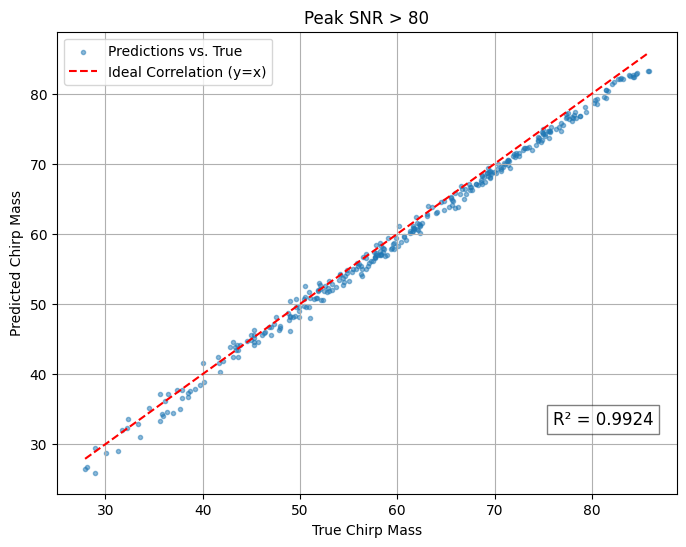

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Set model to evaluation mode
model.eval()

# Store results
predictions = []
true_labels = []

# Disable gradients for evaluation
with torch.no_grad():
    for X_test, y_test in test_loader_80:
        X_test, y_test = X_test.to('cuda'), y_test.to('cuda')

        # Get predictions
        outputs = model(X_test)

        # Store predictions and true labels
        predictions.append(outputs.cpu().numpy())
        true_labels.append(y_test.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Calculate R² score
r2 = r2_score(true_labels, predictions)
print(f"R² Score: {r2:.4f}")

# --- PLOTTING ---
plt.figure(figsize=(8, 6))
plt.scatter(true_labels, predictions, marker='.', alpha=0.5, label="Predictions vs. True")
plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'r--', label="Ideal Correlation (y=x)")

# Add R² annotation
plt.text(0.8, 0.18, f"R² = {r2:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.xlabel("True Chirp Mass")
plt.ylabel("Predicted Chirp Mass")
plt.title("Peak SNR > 80")
plt.legend()
plt.grid(True)

plt.savefig("(5)_Media/Model_1_Final_Performance_SNR80.png")
plt.show()

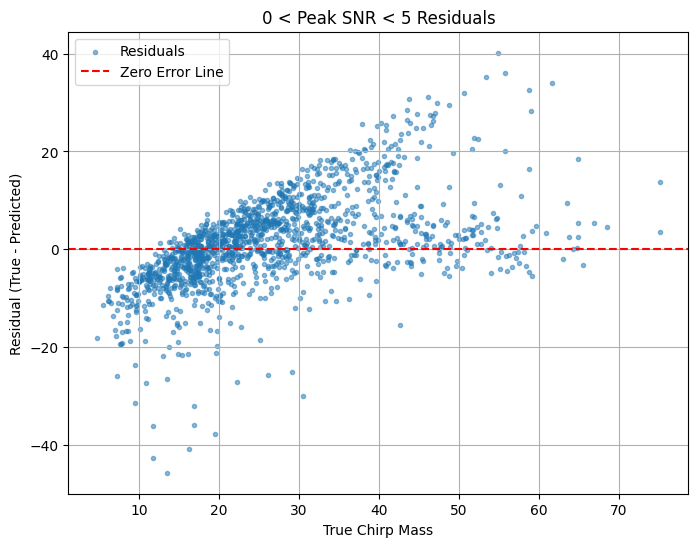

In [28]:
residuals = true_labels - predictions

plt.figure(figsize=(8, 6))
plt.scatter(true_labels, residuals, marker='.', alpha=0.5, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("True Chirp Mass")
plt.ylabel("Residual (True - Predicted)")
plt.title("0 < Peak SNR < 5 Residuals")
plt.legend()
plt.grid(True)
plt.savefig('(5)_Media/Model_1_Final_Performance_Residual_SNR_00.png')
plt.show()

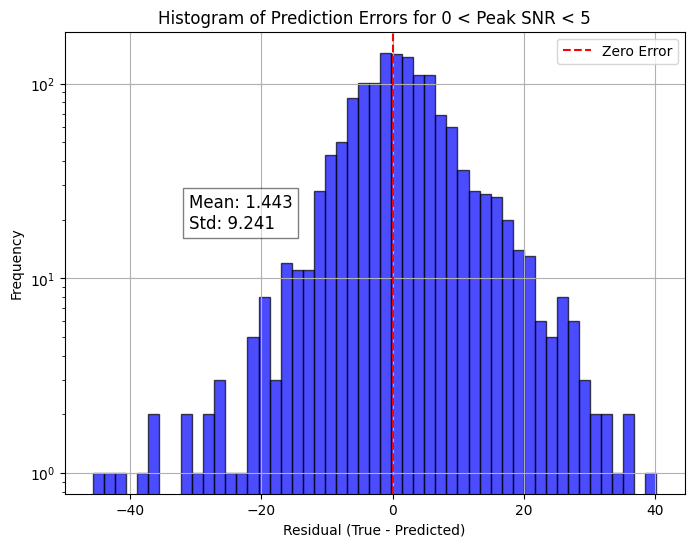

In [29]:
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=51, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label="Zero Error")

# Add text annotation for mean and standard deviation
plt.text(0.2, 0.65, f"Mean: {mean_residual:.3f}\nStd: {std_residual:.3f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.title("Histogram of Prediction Errors for 0 < Peak SNR < 5")
plt.legend()
plt.grid(True)

plt.savefig('(5)_Media/Model_1_Final_Performance_Residual_Histogram_SNR00.png')
plt.show()